In [1]:
import sys
import torch
import tqdm
import numpy as np
import random
import os
import json
sys.path.append('../../')
from models.cnn.search_cnn import  SearchCNN, SearchCNNController
from models.cnn_darts_hypernet.search_cnn_darts_hypernet import SearchCNNControllerWithHyperNet
from models.cnn.one_hot_cnn import OneHotSearchCNNController

from configobj import ConfigObj

In [2]:
import utils
# get data with meta info
input_size, input_channels, n_classes, train_data, valid_data = utils.get_data(
    'fashionmnist', '../../data/', cutout_length=0, validation=True)

test_loader = torch.utils.data.DataLoader(valid_data,
                                           batch_size=64,
                                           shuffle=False,
                                           num_workers=1,
                                           pin_memory=True)

/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


In [3]:
# пример загрузки модели из random-search
seed = 50 # seed нужно выставлять обязательно, он должен соответствовать сиду, из которого проиходило обучение
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
config = ConfigObj('../../configs/mini_fmnist_hyper_final/fmnist_random.cfg')
config['device'] = 'cuda' # если cuda нет, можно и на cpu загрузить
model = OneHotSearchCNNController(**config)
model.load_state_dict(torch.load('../../searchs/mini_fmnist_random/best_{}.pth.tar'.format(seed)))
model.cuda()
model.eval()

KeyError: 'seed'

In [4]:
def accuracy(model, loader):
    total = 0
    correct = 0
    for x,y in loader:
        out = torch.argmax(model(x.cuda()), 1)
        total += x.shape[0]
        correct += torch.eq(out.detach().cpu(), y).numpy().sum()
    return correct/total

#accuracy(model, test_loader)

In [5]:
def param_number(model):
    # Поскольку в нашем дообучении из каждой mixed option берется ровно одна операция,
    # проще просуммировать все операции, которые нами не используются, и вычесть их из общего числа параметров модели    
    blacklist_parameters = 0
    for c in model.net.cells:
        if c.reduction:
            alphas = model.weights_reduce
        else:
            alphas = model.weights_normal
        for node, alpha in zip(c.dag, alphas):
            for mixed_op, alpha_int in zip(node, alpha):                
                ops_to_blacklist = [mixed_op._ops[id] for id in range(len(mixed_op._ops)) if id != alpha_int]
                for op in ops_to_blacklist:
                    for param in op.parameters():
                        blacklist_parameters += np.prod(list(param.shape))
    # считаем количество параметров
    total_parameters = -blacklist_parameters
    for param_name, param in model.net.named_parameters():
        # в DARTS есть еще вспомогательный линейный слой (auxiliary head), который используется, чтобы модель лучше обучалась на
        # первых клетках. Вспомогательный слой используется только на обучении, его не учитывают в параметрах
        # (в нашем текущем эксперименте на маленьких моделях вспомогательного слоя нет, но оставлю эту проверку
        # на будущее)
        if 'aux' in param_name:
            continue
        total_parameters += np.prod(list(param.shape))

    return total_parameters
#param_number(model)            

In [6]:
x,y = [],[]

config = ConfigObj('../../configs/mini_fmnist_hyper_final/fmnist_random.cfg')
config['one-hot']['genotype path'] = '../../configs/mini_fmnist_hyper_final/random_genotype_{}.json'
for seed in config['seeds'].split(';'):
    print (seed)
    seed = int(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    config['seed'] = seed
    config['device'] = 'cuda' # если cuda нет, можно и на cpu загрузить
    model = OneHotSearchCNNController(**config)
    model.load_state_dict(torch.load('../../searchs/mini_fmnist_random/best_{}.pth.tar'.format(seed)))
    model.cuda()
    model.eval()
    x.append(param_number(model))
    y.append(accuracy(model, test_loader))
    del model
    
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [7]:
x0,y0 = [],[]

config = ConfigObj('../../configs/mini_fmnist_hyper_final/fmnist_fine_0.cfg')
config['one-hot']['genotype path'] = '../../searchs/mini_fmnist_darts_hyper/genotype_{}_0_0.json'
for seed in [0,50,100,150,200]:
    print (seed)
    seed = int(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    config['seed'] = seed
    config['device'] = 'cuda' # если cuda нет, можно и на cpu загрузить
    model = OneHotSearchCNNController(**config)
    model.load_state_dict(torch.load('../../searchs/mini_fmnist_fine_0/best_{}.pth.tar'.format(seed)))
    model.cuda()
    model.eval()
    x0.append(param_number(model))
    y0.append(accuracy(model, test_loader))
    del model
    

0
50
100
150
200


In [8]:
x1,y1 = [],[]

config = ConfigObj('../../configs/mini_fmnist_hyper_final/fmnist_fine_1.cfg')
config['one-hot']['genotype path'] = '../../searchs/mini_fmnist_darts_hyper/genotype_{}_1_0.json'
for seed in [0,50,100,150,200]:
    print (seed)
    seed = int(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    config['seed'] = seed
    config['device'] = 'cuda' # если cuda нет, можно и на cpu загрузить
    model = OneHotSearchCNNController(**config)
    model.load_state_dict(torch.load('../../searchs/mini_fmnist_fine_1/best_{}.pth.tar'.format(seed)))
    model.cuda()
    model.eval()
    x1.append(param_number(model))
    y1.append(accuracy(model, test_loader))
    del model
    

0
50
100
150
200


In [9]:
x25,y25 = [],[]

config = ConfigObj('../../configs/mini_fmnist_hyper_final/fmnist_fine_025.cfg')
config['one-hot']['genotype path'] = '../../searchs/mini_fmnist_darts_hyper/genotype_{}_0_25.json'
for seed in [0,50,100,150,200]:
    print (seed)
    seed = int(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    config['seed'] = seed
    config['device'] = 'cuda' # если cuda нет, можно и на cpu загрузить
    model = OneHotSearchCNNController(**config)
    model.load_state_dict(torch.load('../../searchs/mini_fmnist_fine_0_25/best_{}.pth.tar'.format(seed)))
    model.cuda()
    model.eval()
    x25.append(param_number(model))
    y25.append(accuracy(model, test_loader))
    del model
    

0
50
100
150
200


In [10]:
x50,y50 = [],[]

config = ConfigObj('../../configs/mini_fmnist_hyper_final/fmnist_fine_05.cfg')
config['one-hot']['genotype path'] = '../../searchs/mini_fmnist_darts_hyper/genotype_{}_0_5.json'
for seed in [0,50,100,150,200]:
    print (seed)
    seed = int(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    config['seed'] = seed
    config['device'] = 'cuda' # если cuda нет, можно и на cpu загрузить
    model = OneHotSearchCNNController(**config)
    model.load_state_dict(torch.load('../../searchs/mini_fmnist_fine_0_5/best_{}.pth.tar'.format(seed)))
    model.cuda()
    model.eval()
    x50.append(param_number(model))
    y50.append(accuracy(model, test_loader))
    del model
    

0
50
100
150
200


In [11]:
x75,y75 = [],[]

config = ConfigObj('../../configs/mini_fmnist_hyper_final/fmnist_fine_075.cfg')
config['one-hot']['genotype path'] = '../../searchs/mini_fmnist_darts_hyper/genotype_{}_0_75.json'
for seed in [0,50,100,150,200]:
    print (seed)
    seed = int(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    config['seed'] = seed
    config['device'] = 'cuda' # если cuda нет, можно и на cpu загрузить
    model = OneHotSearchCNNController(**config)
    model.load_state_dict(torch.load('../../searchs/mini_fmnist_fine_0_75/best_{}.pth.tar'.format(seed)))
    model.cuda()
    model.eval()
    x75.append(param_number(model))
    y75.append(accuracy(model, test_loader))
    del model
    

0
50
100
150
200


In [12]:
xd,yd = [],[]

config = ConfigObj('../../configs/mini_fmnist_hyper_final/fmnist_fine_darts.cfg')

config['one-hot']['genotype path'] = '../../searchs/mini_fmnist_darts_hyper/darts_genotype_{}.json'
for seed in [0,50,100,150,200]:
    print (seed)
    seed = int(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    config['seed'] = seed
    config['device'] = 'cuda' # если cuda нет, можно и на cpu загрузить
    model = OneHotSearchCNNController(**config)
    model.load_state_dict(torch.load('../../searchs/mini_fmnist_fine_darts/best_{}.pth.tar'.format(seed)))
    model.cuda()
    model.eval()
    xd.append(param_number(model))
    yd.append(accuracy(model, test_loader))
    del model
    

0
50
100
150
200


In [13]:
import matplotlib.pylab as plt
import seaborn as sns
sns.set('paper', font_scale=3)
plt.rcParams['figure.figsize'] = (12,9)
plt.rcParams['font.family'] =  "serif"

In [14]:
#!cat ../../configs/mini_fmnist_hyper_final/fmnist_hyper.cfg
!cat ../../configs/mini_cifar_hyper_final/cifar_hyper.cfg

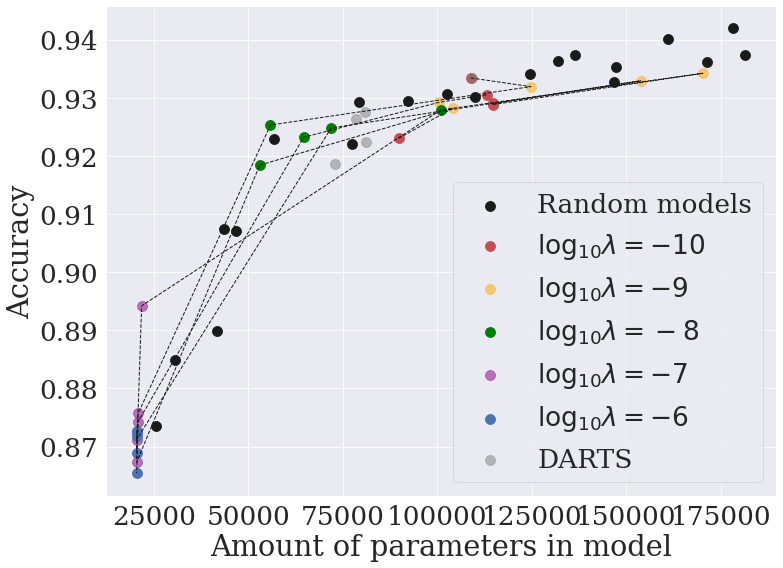

In [14]:
plt.scatter(x,y, c='k', label='Random models', s=100)
plt.scatter(x0,y0, c='r', label='$\log_{10} \lambda={-10}$', s=100)
plt.scatter(x25,y25, c='orange', label='$\log_{10} \lambda={-9}$', s=100, alpha=0.5)
plt.scatter(x50,y50, c='green', label='$\log_{10} \lambda = -8$', s=100)
plt.scatter(x75,y75, c='purple', label='$\log_{10} \lambda={-7}$', s=100, alpha=0.5)
plt.scatter(x1,y1, c='b', label='$\log_{10} \lambda={-6}$', s=100)
plt.scatter(xd,yd, c='gray', label='DARTS', s=100, alpha=0.5)
plt.plot(np.array([x0,x25,x50,x75,x1]), np.array([y0,y25,y50,y75,y1]), c='k', lw=1, ls='--')
plt.legend(loc='best')
plt.xlabel('Amount of parameters in model')
plt.ylabel('Accuracy')
plt.savefig('fmnist_scatter.pdf')


In [1]:
# калибровка: (-10, -6): модели переусложненные, хочется, чтобы единица была ниже
# OK: ставим 5 штук

In [31]:
np.array([x0,x50,x1]).T

array([[114666, 101018,  20506],
       [114874,  71962,  20506],
       [ 89770,  53050,  20506]])